In [39]:
# Sports Analytics: Final Semester Project & Portfolio

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
years = list(range(2008, 2025))  # 2008–2024
base_url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/"

all_matches = []

for year in years:
    url = base_url + f"atp_matches_{year}.csv"
    print(f"Loading {url} ...")
    df_year = pd.read_csv(url)
    df_year["match_year"] = year
    all_matches.append(df_year)

matches_2008_2024 = pd.concat(all_matches, ignore_index=True)
print("Merged shape (raw):", matches_2008_2024.shape)



Loading https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2008.csv ...
Loading https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2009.csv ...
Loading https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2010.csv ...
Loading https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2011.csv ...
Loading https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2012.csv ...
Loading https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2013.csv ...
Loading https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2014.csv ...
Loading https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2015.csv ...
Loading https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2016.csv ...
Loading https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2017.csv ...
Loading https://raw.

In [42]:
# Filter to completed matches only: non-null score, no WO/RET/etc.
if "comment" in matches_2008_2024.columns:
    mask_completed = matches_2008_2024["comment"].isna()
    matches_2008_2024 = matches_2008_2024[mask_completed]

matches_2008_2024 = matches_2008_2024[matches_2008_2024["score"].notna()]

print("Shape after completed-match filter:", matches_2008_2024.shape)

# Save merged + basic-filtered dataset
output_filename = "atp_matches_2008_2024_merged.csv"
matches_2008_2024.to_csv(output_filename, index=False)
print("Merged dataset saved as:", output_filename)


Shape after completed-match filter: (48779, 50)
Merged dataset saved as: atp_matches_2008_2024_merged.csv


In [43]:
df = pd.read_csv("atp_matches_2008_2024_merged.csv")
print("Reloaded df shape:", df.shape)
df.head()



Reloaded df shape: (48779, 50)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,match_year
0,2008-1536,Madrid Masters,Hard,48,M,20081012,1,105208,NaN,NaN,...,42.0,26.0,17.0,3.0,5.0,54.0,719.0,27.0,1120.0,2008
1,2008-1536,Madrid Masters,Hard,48,M,20081012,2,103888,NaN,NaN,...,14.0,15.0,8.0,1.0,4.0,25.0,1145.0,59.0,694.0,2008
2,2008-1536,Madrid Masters,Hard,48,M,20081012,3,104259,NaN,NaN,...,19.0,8.0,8.0,5.0,9.0,31.0,1065.0,46.0,805.0,2008
3,2008-1536,Madrid Masters,Hard,48,M,20081012,4,103852,NaN,NaN,...,31.0,22.0,10.0,4.0,5.0,40.0,865.0,48.0,777.0,2008
4,2008-1536,Madrid Masters,Hard,48,M,20081012,5,103812,NaN,Q,...,36.0,14.0,13.0,4.0,8.0,73.0,579.0,26.0,1123.0,2008


In [44]:
# 1. Ensure completed matches (defensive re-check)
df = df[df['score'].notna()]
if 'comment' in df.columns:
    df = df[df['comment'].isna()]

# 2. Remove doubles matches (keep singles only)
df = df[df["tourney_level"] != "D"]

# 3. Remove qualifying and round-robin rounds
df = df[~df['round'].isin(['Q1', 'Q2', 'Q3', 'Q', 'RR'])]

# 4. Create unique match key (one row = one ATP singles match)
df['unique_key'] = df['tourney_id'].astype(str) + "_" + df['match_num'].astype(str)

# 5. Standardize surface labels and convert tourney_date to datetime
df['surface'] = df['surface'].str.strip().str.title()
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')

print("Shape after singles + rounds + key + standardization:", df.shape)




Shape after singles + rounds + key + standardization: (43748, 51)


In [45]:
print("Row count after filters:", len(df))
print("Duplicate unique keys:", df['unique_key'].duplicated().sum())


Row count after filters: 43748
Duplicate unique keys: 0


In [46]:
# Remove any rows where serve points is zero (just in case)
df = df[(df['w_svpt'] > 0) & (df['l_svpt'] > 0)]

# Winner serve-return balance
df['w_srv_ret_balance'] = (df['w_1stWon'] + df['w_2ndWon']) / df['w_svpt']

# Loser serve-return balance
df['l_srv_ret_balance'] = (df['l_1stWon'] + df['l_2ndWon']) / df['l_svpt']

# Efficiency difference (winner - loser)
df['efficiency_diff'] = df['w_srv_ret_balance'] - df['l_srv_ret_balance']

print("Shape after feature engineering:", df.shape)
df[['w_srv_ret_balance', 'l_srv_ret_balance', 'efficiency_diff']].head()




Shape after feature engineering: (43366, 54)


,w_srv_ret_balance,l_srv_ret_balance,efficiency_diff
0,0.696970,0.715789,-0.018820
1,0.759259,0.568627,0.190632
2,0.723404,0.465517,0.257887
3,0.819672,0.616279,0.203393
4,0.678571,0.574713,0.103859


In [47]:
df[['w_ace', 'l_ace', 'w_df', 'l_df']].describe()



,w_ace,l_ace,w_df,l_df
count,43366.000000,43366.000000,43366.000000,43366.000000
mean,7.161509,5.278628,2.574090,3.246506
std,5.691372,4.998485,2.234089,2.464529
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,1.000000,1.000000
50%,6.000000,4.000000,2.000000,3.000000
75%,10.000000,7.000000,4.000000,4.000000
max,113.000000,103.000000,26.000000,26.000000


In [48]:
df.isna().mean().sort_values(ascending=False)



,0
winner_entry,0.853180
loser_entry,0.762026
loser_seed,0.742194
winner_seed,0.530738
minutes,0.036872
loser_ht,0.003643
loser_rank_points,0.002306
loser_rank,0.002306
winner_ht,0.000530
winner_rank,0.000415


In [49]:
# Validation Gates

In [50]:
df.isna().mean().sort_values(ascending=False)



,0
winner_entry,0.853180
loser_entry,0.762026
loser_seed,0.742194
winner_seed,0.530738
minutes,0.036872
loser_ht,0.003643
loser_rank_points,0.002306
loser_rank,0.002306
winner_ht,0.000530
winner_rank,0.000415


In [51]:
# Clean Dataset!!

In [52]:
print("Row count after cleaning:", len(df))
print("Duplicate unique keys:", df['unique_key'].duplicated().sum())

print("\nMissingness by column (top 15):")
print(df.isna().mean().sort_values(ascending=False).head(15))


Row count after cleaning: 43366
Duplicate unique keys: 0

Missingness by column (top 15):
winner_entry          0.853180
loser_entry           0.762026
loser_seed            0.742194
winner_seed           0.530738
minutes               0.036872
loser_ht              0.003643
loser_rank_points     0.002306
loser_rank            0.002306
winner_ht             0.000530
winner_rank           0.000415
winner_rank_points    0.000415
w_SvGms               0.000023
l_SvGms               0.000023
tourney_date          0.000000
winner_ioc            0.000000
dtype: float64


In [53]:
# Data Dictionary

In [54]:
df.to_csv("atp_matches_2008_2024_clean.csv", index=False)
print("Clean dataset exported as: atp_matches_2008_2024_clean.csv")



Clean dataset exported as: atp_matches_2008_2024_clean.csv


In [55]:
# Export final cleaned dataset
clean_filename = "atp_matches_2008_2024_clean.csv"
df.to_csv(clean_filename, index=False)
print("Clean dataset exported as:", clean_filename)


Clean dataset exported as: atp_matches_2008_2024_clean.csv


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("atp_matches_2008_2024_clean.csv")

sns.set(style="whitegrid")


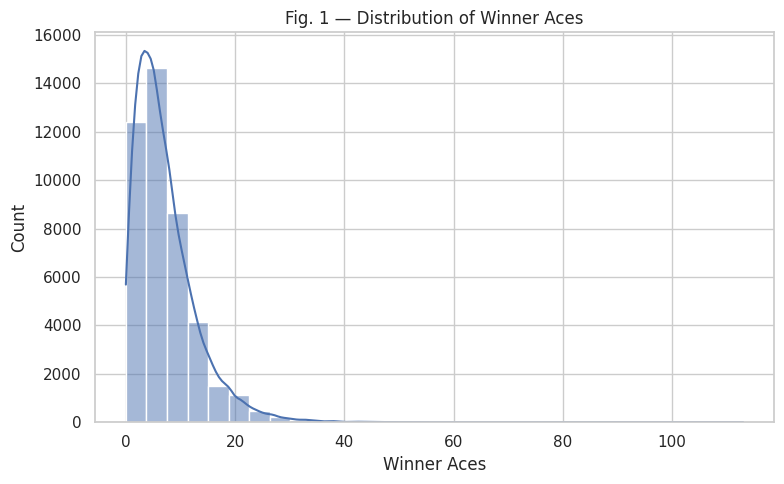

In [57]:
#Figure 1: Winner & Aces

plt.figure(figsize=(8,5))
sns.histplot(df['w_ace'], bins=30, kde=True)
plt.title("Fig. 1 — Distribution of Winner Aces")
plt.xlabel("Winner Aces")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("fig1_winner_aces.png")
plt.show()


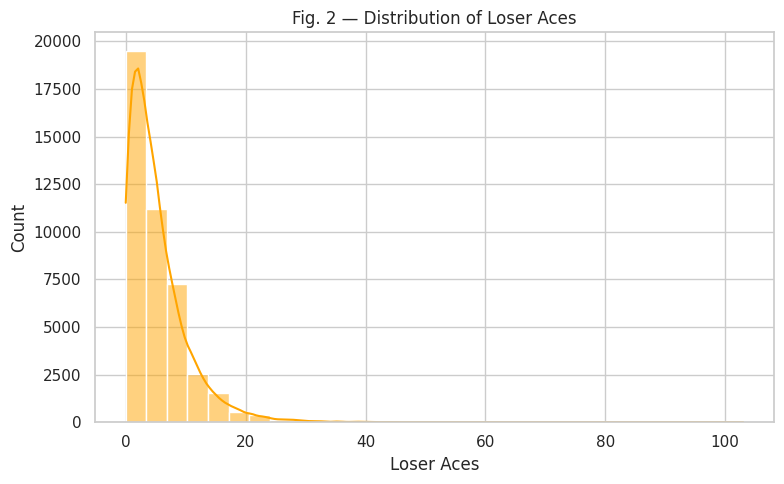

In [58]:
#Figure 2: Loser & Aces

plt.figure(figsize=(8,5))
sns.histplot(df['l_ace'], bins=30, kde=True, color='orange')
plt.title("Fig. 2 — Distribution of Loser Aces")
plt.xlabel("Loser Aces")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("fig2_loser_aces.png")
plt.show()


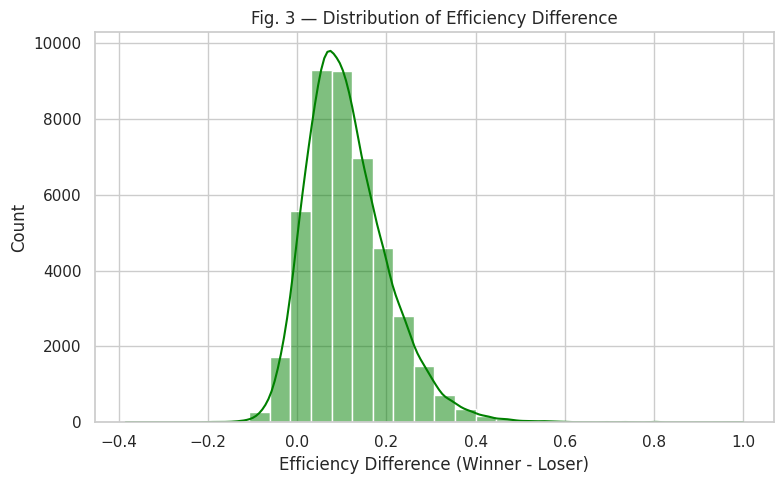

In [59]:
# Figure 3: Efficiency

plt.figure(figsize=(8,5))
sns.histplot(df['efficiency_diff'], bins=30, kde=True, color='green')
plt.title("Fig. 3 — Distribution of Efficiency Difference")
plt.xlabel("Efficiency Difference (Winner - Loser)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("fig3_efficiency_diff.png")
plt.show()


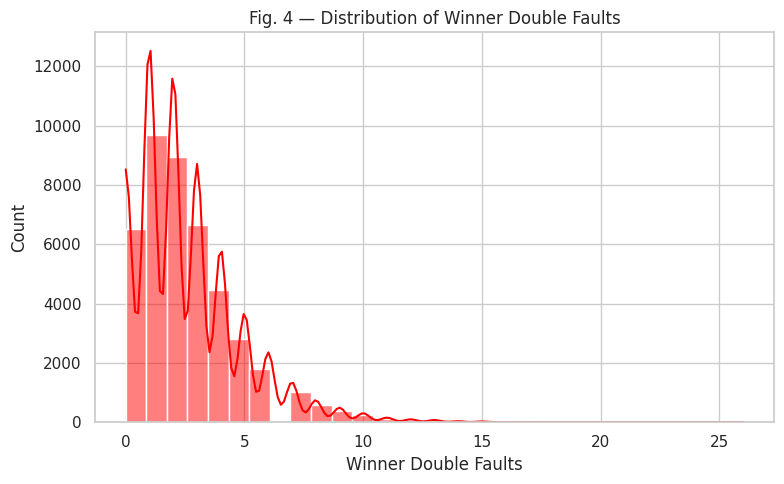

In [60]:
#Figure 4: Double Faults

plt.figure(figsize=(8,5))
sns.histplot(df['w_df'], bins=30, kde=True, color='red')
plt.title("Fig. 4 — Distribution of Winner Double Faults")
plt.xlabel("Winner Double Faults")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("fig4_winner_df.png")
plt.show()


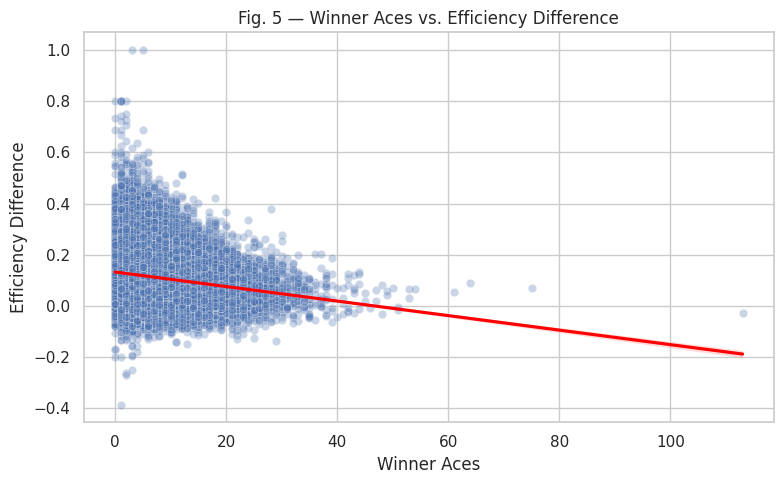

In [61]:
# Figure 5: Winner Aces vs Efficiency

plt.figure(figsize=(8,5))
sns.scatterplot(x=df['w_ace'], y=df['efficiency_diff'], alpha=0.3)
sns.regplot(x=df['w_ace'], y=df['efficiency_diff'], scatter=False, color='red')
plt.title("Fig. 5 — Winner Aces vs. Efficiency Difference")
plt.xlabel("Winner Aces")
plt.ylabel("Efficiency Difference")
plt.tight_layout()
plt.savefig("fig5_aces_vs_eff.png")
plt.show()


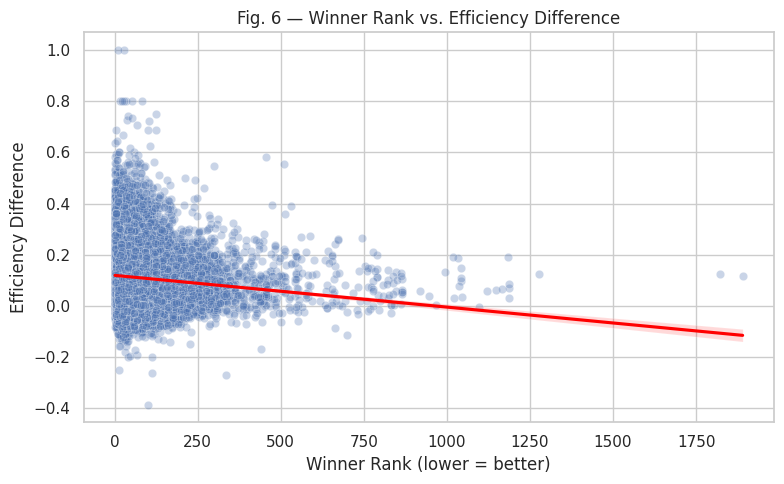

In [62]:
# Figure 6

plt.figure(figsize=(8,5))
sns.scatterplot(x=df['winner_rank'], y=df['efficiency_diff'], alpha=0.3)
sns.regplot(x=df['winner_rank'], y=df['efficiency_diff'], scatter=False, color='red')
plt.title("Fig. 6 — Winner Rank vs. Efficiency Difference")
plt.xlabel("Winner Rank (lower = better)")
plt.ylabel("Efficiency Difference")
plt.tight_layout()
plt.savefig("fig6_rank_vs_eff.png")
plt.show()


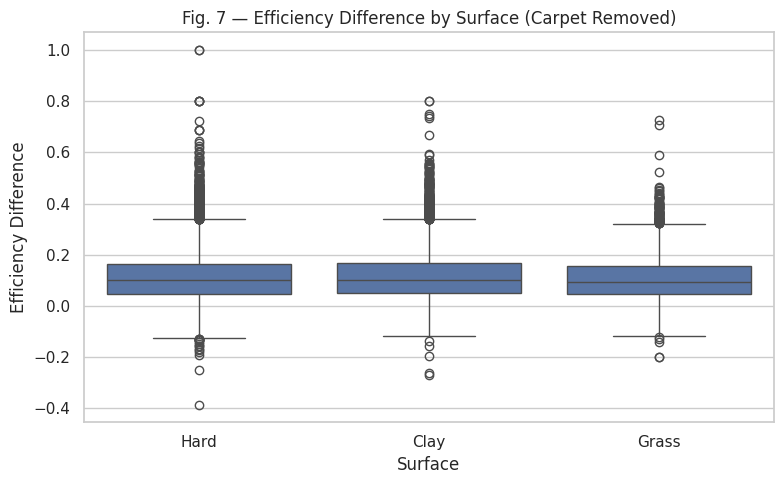

In [63]:
# Figure 7

# Remove 'Carpet' surface if present
df_surface = df[df['surface'].isin(['Hard', 'Clay', 'Grass'])]

plt.figure(figsize=(8,5))
sns.boxplot(x=df_surface['surface'], y=df_surface['efficiency_diff'])
plt.title("Fig. 7 — Efficiency Difference by Surface (Carpet Removed)")
plt.xlabel("Surface")
plt.ylabel("Efficiency Difference")
plt.tight_layout()
plt.savefig("fig7_surface_eff_cleaned.png")
plt.show()



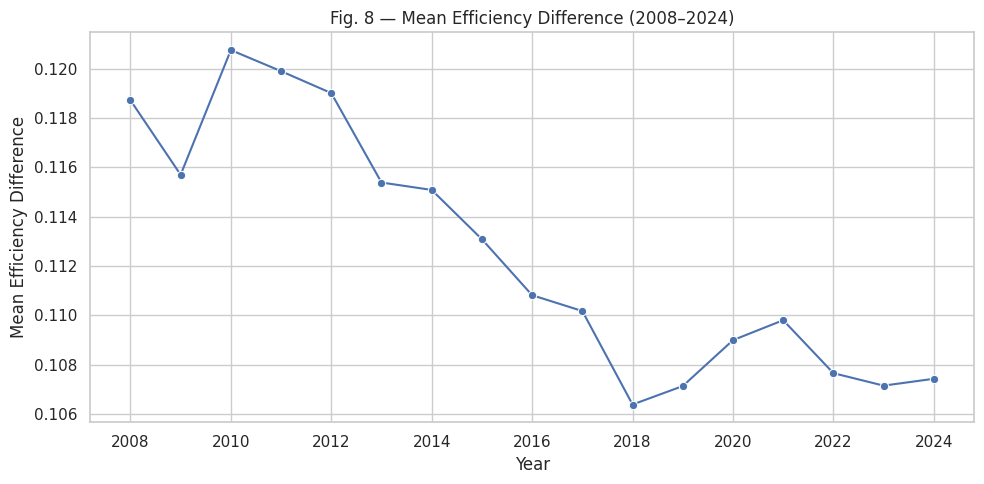

In [64]:
# Figure 8:

yearly = df.groupby('match_year')['efficiency_diff'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=yearly, x='match_year', y='efficiency_diff', marker="o")
plt.title("Fig. 8 — Mean Efficiency Difference (2008–2024)")
plt.xlabel("Year")
plt.ylabel("Mean Efficiency Difference")
plt.tight_layout()
plt.savefig("fig8_eff_by_year.png")
plt.show()


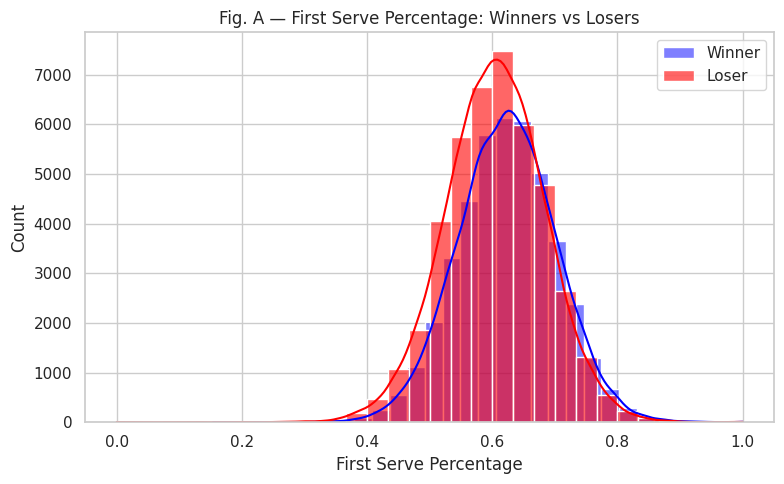

In [65]:
# Figure 9: First Serve % of Winners vs Losers of Match

df['w_first_serve_pct'] = df['w_1stIn'] / df['w_svpt']
df['l_first_serve_pct'] = df['l_1stIn'] / df['l_svpt']

plt.figure(figsize=(8,5))
sns.histplot(df['w_first_serve_pct'], color='blue', label='Winner', kde=True, bins=30)
sns.histplot(df['l_first_serve_pct'], color='red', label='Loser', kde=True, bins=30, alpha=0.6)
plt.title("Fig. A — First Serve Percentage: Winners vs Losers")
plt.xlabel("First Serve Percentage")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("figA_first_serve_pct.png")
plt.show()



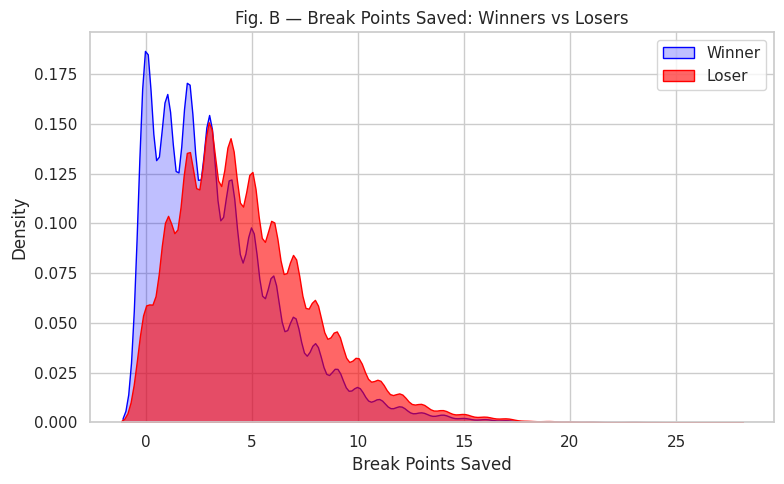

In [66]:
# Figure 10: Break Points Saved, Winners vs Losers

plt.figure(figsize=(8,5))
sns.kdeplot(df['w_bpSaved'], color='blue', label='Winner', fill=True)
sns.kdeplot(df['l_bpSaved'], color='red', label='Loser', fill=True, alpha=0.6)
plt.title("Fig. B — Break Points Saved: Winners vs Losers")
plt.xlabel("Break Points Saved")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("figB_breakpoints_saved.png")
plt.show()


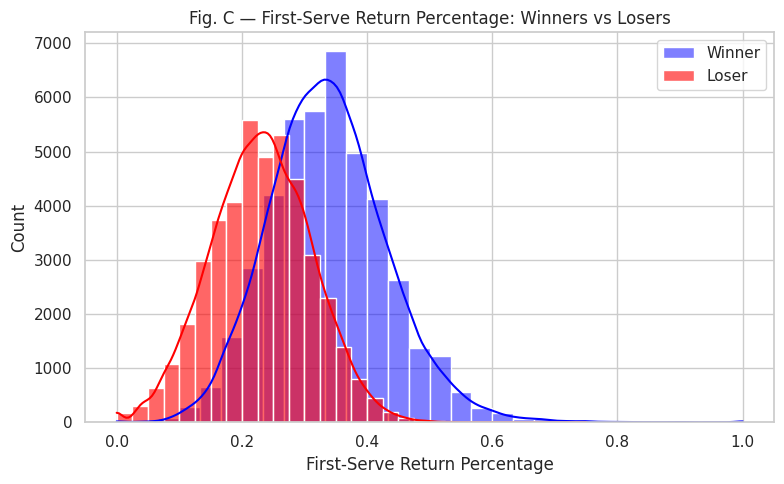

In [67]:
# Figure 11: Return Points Won, Winners vs Losers of Matches

w_return_1stWon = df['l_1stIn'] - df['l_1stWon']
l_return_1stWon = df['w_1stIn'] - df['w_1stWon']

w_return_1stPct = w_return_1stWon / df['l_1stIn']
l_return_1stPct = l_return_1stWon / df['w_1stIn']

# Compute first-serve return points won
df['w_return_1stWon'] = df['l_1stIn'] - df['l_1stWon']
df['l_return_1stWon'] = df['w_1stIn'] - df['w_1stWon']

# Compute first-serve return percentage (avoid division by zero)
df['w_ret_1st_pct'] = df['w_return_1stWon'] / df['l_1stIn'].replace(0, np.nan)
df['l_ret_1st_pct'] = df['l_return_1stWon'] / df['w_1stIn'].replace(0, np.nan)

plt.figure(figsize=(8,5))
sns.histplot(df['w_ret_1st_pct'], bins=30, kde=True, label='Winner', color='blue')
sns.histplot(df['l_ret_1st_pct'], bins=30, kde=True, alpha=0.6, label='Loser', color='red')
plt.title("Fig. C — First-Serve Return Percentage: Winners vs Losers")
plt.xlabel("First-Serve Return Percentage")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("figC_first_serve_return_pct.png")
plt.show()

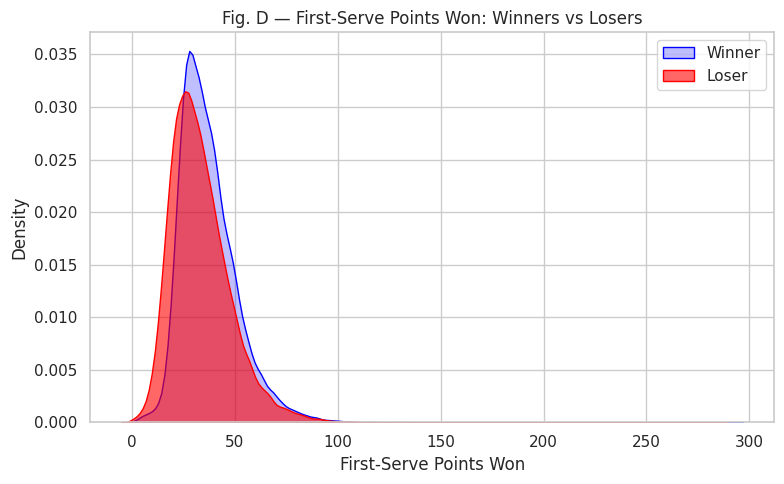

In [68]:
# Figure 12: First Serve Points Won

# Figure D: First-Serve Points Won, Winners vs Losers

plt.figure(figsize=(8,5))
sns.kdeplot(df['w_1stWon'], color='blue', label='Winner', fill=True)
sns.kdeplot(df['l_1stWon'], color='red', label='Loser', fill=True, alpha=0.6)

plt.title("Fig. D — First-Serve Points Won: Winners vs Losers")
plt.xlabel("First-Serve Points Won")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("figD_first_serve_points_won.png")
plt.show()


In [69]:
# Logistic Regression (CP6 and beyond)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np



In [70]:
# Build player-level dataset from the cleaned match-level df (2008–2024 only)

# Winner rows
winner_rows = pd.DataFrame({
    "match_id": df["unique_key"],
    "player_role": "winner",
    "outcome": 1,
    "player_srv_ret_balance": df["w_srv_ret_balance"],
    "player_first_serve_pct": df["w_first_serve_pct"],
    "player_ret_1st_pct": df["w_ret_1st_pct"],
    "player_1st_points_won": df["w_1stWon"],
    "player_rank": df["winner_rank"],
    "surface": df["surface"],
    "match_year": df["match_year"]
})

# Loser rows
loser_rows = pd.DataFrame({
    "match_id": df["unique_key"],
    "player_role": "loser",
    "outcome": 0,
    "player_srv_ret_balance": df["l_srv_ret_balance"],
    "player_first_serve_pct": df["l_first_serve_pct"],
    "player_ret_1st_pct": df["l_ret_1st_pct"],
    "player_1st_points_won": df["l_1stWon"],
    "player_rank": df["loser_rank"],
    "surface": df["surface"],
    "match_year": df["match_year"]
})

# Combine winner + loser into one modeling dataframe
model_df = pd.concat([winner_rows, loser_rows], ignore_index=True)

# Drop any rows with missing key predictors
model_df = model_df.dropna(subset=[
    "player_srv_ret_balance",
    "player_first_serve_pct",
    "player_ret_1st_pct",
    "player_1st_points_won",
    "player_rank"
])

print("Modeling dataframe shape (rows, cols):", model_df.shape)
model_df.head()



Modeling dataframe shape (rows, cols): (86612, 10)


,match_id,player_role,outcome,player_srv_ret_balance,player_first_serve_pct,player_ret_1st_pct,player_1st_points_won,player_rank,surface,match_year
0,2008-1536_1,winner,1,0.696970,0.636364,0.176471,48.0,54.0,Hard,2008
1,2008-1536_2,winner,1,0.759259,0.462963,0.461538,24.0,25.0,Hard,2008
2,2008-1536_3,winner,1,0.723404,0.595745,0.472222,22.0,31.0,Hard,2008
3,2008-1536_4,winner,1,0.819672,0.606557,0.354167,34.0,40.0,Hard,2008
4,2008-1536_5,winner,1,0.678571,0.678571,0.419355,48.0,73.0,Hard,2008


In [71]:
# Outcome and baseline predictor
y = model_df["outcome"]  # 1 = winner, 0 = loser
X_baseline = model_df[["player_srv_ret_balance"]]

# Train/test split (stratified keeps winner/loser balance)
X_train_base, X_test_base, y_train, y_test = train_test_split(
    X_baseline, y, test_size=0.3, random_state=42, stratify=y
)

# Majority-class baseline accuracy (should be ~0.50 because of balance)
baseline_accuracy = y_test.value_counts(normalize=True).max()
print("Baseline (majority-class) accuracy:", round(baseline_accuracy, 3))


Baseline (majority-class) accuracy: 0.5


In [72]:
# Model 1: Logistic regression with player_srv_ret_balance only

log_reg1 = LogisticRegression(solver="liblinear")
log_reg1.fit(X_train_base, y_train)

y_pred1 = log_reg1.predict(X_test_base)
acc1 = accuracy_score(y_test, y_pred1)

print("Model 1 Accuracy (efficiency only):", round(acc1, 3))
print("\nConfusion Matrix (Model 1):\n", confusion_matrix(y_test, y_pred1))
print("\nClassification Report (Model 1):\n", classification_report(y_test, y_pred1))

# Coefficient table
coef1 = pd.DataFrame({
    "Predictor": ["player_srv_ret_balance"],
    "Coefficient": log_reg1.coef_[0]
})
coef1


Model 1 Accuracy (efficiency only): 0.787

Confusion Matrix (Model 1):
 [[10164  2816]
 [ 2727 10277]]

Classification Report (Model 1):
               precision    recall  f1-score   support

           0       0.79      0.78      0.79     12980
           1       0.78      0.79      0.79     13004

    accuracy                           0.79     25984
   macro avg       0.79      0.79      0.79     25984
weighted avg       0.79      0.79      0.79     25984



,Predictor,Coefficient
0,player_srv_ret_balance,23.174324


In [73]:
# Model 2: Logistic regression with efficiency + first-serve return % + first-serve points won

predictors_model2 = ["player_srv_ret_balance",
                     "player_ret_1st_pct",
                     "player_1st_points_won"]

X2 = model_df[predictors_model2]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y, test_size=0.3, random_state=42, stratify=y
)

log_reg2 = LogisticRegression(solver="liblinear")
log_reg2.fit(X_train2, y_train2)

y_pred2 = log_reg2.predict(X_test2)
acc2 = accuracy_score(y_test2, y_pred2)

print("Model 2 Accuracy (efficiency + return + 1st-serve points won):", round(acc2, 3))
print("\nConfusion Matrix (Model 2):\n", confusion_matrix(y_test2, y_pred2))
print("\nClassification Report (Model 2):\n", classification_report(y_test2, y_pred2))

coef2 = pd.DataFrame({
    "Predictor": predictors_model2,
    "Coefficient": log_reg2.coef_[0]
})
coef2


Model 2 Accuracy (efficiency + return + 1st-serve points won): 0.878

Confusion Matrix (Model 2):
 [[11399  1581]
 [ 1585 11419]]

Classification Report (Model 2):
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     12980
           1       0.88      0.88      0.88     13004

    accuracy                           0.88     25984
   macro avg       0.88      0.88      0.88     25984
weighted avg       0.88      0.88      0.88     25984



,Predictor,Coefficient
0,player_srv_ret_balance,29.243673
1,player_ret_1st_pct,20.664579
2,player_1st_points_won,0.006476
